# SIT307 - Machine Learning Challenge (Assignment 3)

Our chosen dataset is [Life Expectancy (WHO)](https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who).

Prepared by

| Student           | Student ID |
|-------------------|------------|
| HOOMAN SHYKHIPOUR | 220060109  |
| SARAH GOSLING     | 220094149  |
| DEVIN JAYASINGHE  | 220228075  |
| RYAN WAITES       | 215127684  |
| ANTHONY GEORGE    | 220180567  |
| MATT KINNIA       | 219311697  |

In [38]:
'''
Import all necessary libraries
'''

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Import the required packages for our regression models.
from statistics import mean
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import lars_path

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Ignore inline warnings thrown by packages
warnings.filterwarnings("ignore")

In [3]:
'''
Get our cleaned dataset
'''

life_df = pd.read_csv('Cleaned_Life_Expectancy_Data.csv', delimiter=',')

# Section 1: Introduction

# Section 2: Machine Learning

## Section 2.1: Regression

In [4]:
'''
Let's organise our features to use in our regression model
'''

# Convert country, a categorical text field, to a numerical class should we wish to use it in any models.
label_encoder = LabelEncoder()
life_df["COUNTRY_CLASS"] = label_encoder.fit_transform(life_df["COUNTRY"])

# Pull the required columns from the source dataset.
reg_life_df = life_df[["STATUS", "LIFE_EXPECTANCY", "ALCOHOL", "ADULT_MORTALITY","MEASLES","POLIO","DIPHTHERIA", "BMI", "INFANT_DEATHS","THINNESS_5-9_YEARS","THINNESS_10-19_YEARS", "SCHOOLING","INCOME_COMPOSITION_OF_RESOURCES"]]
reg_life_df = reg_life_df.dropna()

# Define our x (independent) and y (dependent) variables for our regression models.
x = reg_life_df[["STATUS", "ALCOHOL", "ADULT_MORTALITY", "BMI", "INFANT_DEATHS","MEASLES","POLIO","DIPHTHERIA","THINNESS_5-9_YEARS","THINNESS_10-19_YEARS", "SCHOOLING","INCOME_COMPOSITION_OF_RESOURCES"]]
y = reg_life_df["LIFE_EXPECTANCY"]

In [5]:
# Split our dataset into training and testing samples. We are using 80% for training and 20% for testing.
# NOTE: Using a the "random_state" parameter ensures we get repeatable results for each execution.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Scale our train and test features using standardization.
std_scaler = StandardScaler()
std_scaler.fit(x_train.values)

x_train_scaled = std_scaler.transform(x_train.values)
x_test_scaled  = std_scaler.transform(x_test.values)

### Linear Regression

Using an ordinary least squares Linear Regression model we can predict `LIFE_EXPECTANCY` using a one or more explanatory features.

In [6]:
# Create and train the ordinary least squares Linear Regression model based on our training data.
linear_regression = LinearRegression()
linear_regression.fit(x_train_scaled, y_train)

LinearRegression()

In [7]:
# Run a prediction using our testing data.
y_pred = linear_regression.predict(x_test_scaled)

#### Performance

In [8]:
# Print the model's performance indicators.
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")  
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")  
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred))}")

Coefficient of determination: 0.9238680302251875
Mean Absolute Error: 1.8176607104482654
Mean Squared Error: 6.530865259277718
Root Mean Squared Error: 2.555555763288627


In [9]:
# Print actual vs predicted values. 
pd.DataFrame({"Actual": y_test, "Predicted": y_pred}).head()

,Actual,Predicted
783,70.2,68.608839
1615,69.6,68.791612
410,53.3,54.768536
1852,79.1,79.510794
523,45.7,44.771927


[Text(0.5, 1.0, 'Actual vs. Predicted Life Expectancy'),
 Text(0.5, 0, 'Actual Value'),
 Text(0, 0.5, 'Predicted Value')]

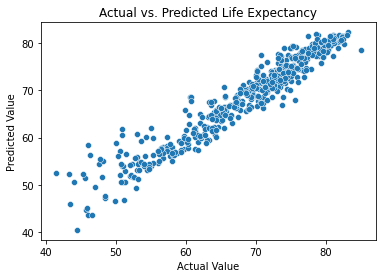

In [10]:
# Plot actual vs predicted values.
plot = sns.scatterplot(x=y_test, y=y_pred)
plot.set(title="Actual vs. Predicted Life Expectancy", xlabel="Actual Value", ylabel="Predicted Value")

#### Prediction

Predict life expectancy using previously unseen data.

In [11]:
# Provide a set of previously unseen features.
# STATUS, ALCOHOL, ADULT_MORTALITY, BMI, INFANT_DEATHS, MEASLES, POLIO, DIPHTHERIA, THINNESS_5-9_YEARS, THINNESS_10-19_YEARS, SCHOOLING, INCOME_COMPOSITION_OF_RESOURCES
new_features = [[0, 5, 300, 19, 82, 1495, 68, 40, 18, 17, 14, 0.5]]

# Scale these features using standardization 
new_features_scaled = std_scaler.transform(new_features)

# Predict the life expectancy given the new features
new_pred = linear_regression.predict(new_features_scaled)
print(f"Given provided features, the predicted life expectancy is: {new_pred[0]}")

Given provided features, the predicted life expectancy is: 55.88050060426038


### Lasso Regression 

####  finding best ALPHA value for L1 regularization,implementing lassoCV

In [12]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-3,3,200)   # alpha varies from 0.001 to 1000
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(x_train_scaled, y_train)
# This is the best alpha value found
lasso_model.alpha_ 


0.012173827277396614

In [13]:
# showing all coefficients with optimal alpha
list(zip(x_train.columns, lasso_model.coef_))

[('STATUS', 0.1254014418298149),
 ('ALCOHOL', -0.01712369191563245),
 ('ADULT_MORTALITY', -4.479060598744764),
 ('BMI', 0.1818122224565193),
 ('INFANT_DEATHS', 0.15874142618205453),
 ('MEASLES', -0.2850918092368943),
 ('POLIO', -0.0),
 ('DIPHTHERIA', 1.0785488519160238),
 ('THINNESS_5-9_YEARS', -0.036196874877915786),
 ('THINNESS_10-19_YEARS', -0.11107439652977473),
 ('SCHOOLING', 0.0),
 ('INCOME_COMPOSITION_OF_RESOURCES', 3.9669492280262615)]

In [14]:
# Run a prediction using our testing data.
y_pred_LASSO = lasso_model.predict(x_test_scaled)

#### Performance

In [15]:
# Print the model's performance indicators.
print(f"Coefficient of determination: {r2_score(y_test, y_pred_LASSO)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_LASSO)}")  
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_LASSO)}")  
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred_LASSO))}")

Coefficient of determination: 0.9240796076950468
Mean Absolute Error: 1.816059783150613
Mean Squared Error: 6.512715407754935
Root Mean Squared Error: 2.552002235060725


In [16]:
# Print actual vs predicted values. 
pd.DataFrame({"Actual": y_test, "Predicted": y_pred_LASSO}).head()

,Actual,Predicted
783,70.2,68.455940
1615,69.6,68.862125
410,53.3,55.087929
1852,79.1,79.374050
523,45.7,44.632764


[Text(0.5, 1.0, 'Actual vs. Predicted Life Expectancy'),
 Text(0.5, 0, 'Actual Value'),
 Text(0, 0.5, 'Predicted Value')]

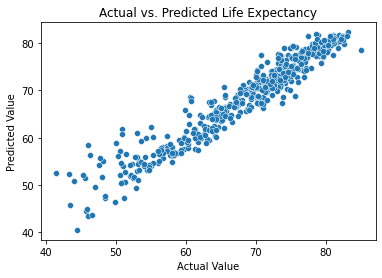

In [17]:
# Plot actual vs predicted values.
plot = sns.scatterplot(x=y_test, y=y_pred_LASSO)
plot.set(title="Actual vs. Predicted Life Expectancy", xlabel="Actual Value", ylabel="Predicted Value")

#### Prediction

In [18]:
# Provide a set of previously unseen features.
# STATUS, ALCOHOL, ADULT_MORTALITY, BMI, INFANT_DEATHS, MEASLES, POLIO, DIPHTHERIA, THINNESS_5-9_YEARS, THINNESS_10-19_YEARS, SCHOOLING, INCOME_COMPOSITION_OF_RESOURCES
new_features = [[0, 5, 300, 19, 82, 1495, 68, 40, 18, 17, 14, 0.5]]

# Scale these features using standardization 
new_features_scaled = std_scaler.transform(new_features)

# Predict the life expectancy given the new features
new_pred = lasso_model.predict(new_features_scaled)
print(f"Given provided features, the predicted life expectancy is: {new_pred[0]}")

Given provided features, the predicted life expectancy is: 56.55860127593329


In [19]:
# Regularization path computation using the LARS
alphas, _, coefs = lars_path(x_train_scaled, y_train.values, method='lasso')

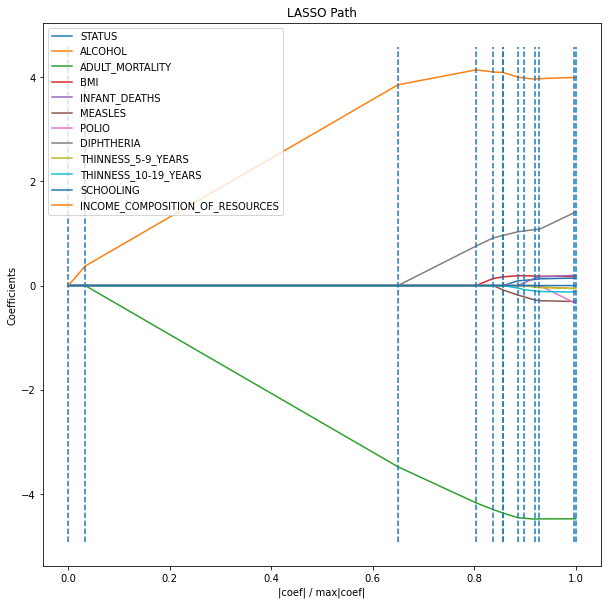

In [20]:
# plotting the LARS path
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(x_train.columns)
plt.show()

### Artificial Neural Network

In [21]:
reg_life_df.shape

(2736, 13)

In [22]:
# Pull the required columns from the source dataset.
x = reg_life_df[["STATUS", "ALCOHOL", "ADULT_MORTALITY", "BMI", "INFANT_DEATHS","MEASLES","POLIO","DIPHTHERIA","THINNESS_5-9_YEARS","THINNESS_10-19_YEARS", "SCHOOLING","INCOME_COMPOSITION_OF_RESOURCES"]]

In [23]:
print(len(x))

2736


In [24]:
# split dataset into train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# standardise the features individually before applying ML
sc=StandardScaler()

# fit standardised features
scaler = sc.fit(x_train)

# transform train and test data
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

#mlp = MLPRegressor(random_state=1, max_iter=10000).fit(x_train, y_train)
mlp = MLPRegressor(hidden_layer_sizes=(150),
                   max_iter = 10000, 
                   activation = 'relu',
                   solver = 'adam').fit(x_train_scaled, y_train)

# get prediction from test data 
predict_test = mlp.predict(x_test_scaled)

In [25]:
# print coefficients and errors
print(f"Coefficient of determination: {r2_score(y_test, predict_test)}")
print('Mean Absolute Error:', mean_absolute_error(y_test, predict_test))  
print('Mean Squared Error:', mean_squared_error(y_test, predict_test))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predict_test)))

Coefficient of determination: 0.9566671033074434
Mean Absolute Error: 1.3163707023913844
Mean Squared Error: 3.717246649868186
Root Mean Squared Error: 1.9280162473039968


[Text(0.5, 1.0, 'Actual vs. Predicted Life Expectancy'),
 Text(0.5, 0, 'Actual Value'),
 Text(0, 0.5, 'Predicted Value')]

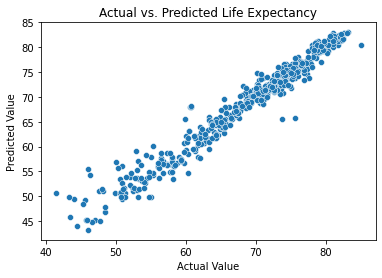

In [26]:
# Plot actual vs predicted values.
plot = sns.scatterplot(x=y_test, y=predict_test)
plot.set(title="Actual vs. Predicted Life Expectancy", xlabel="Actual Value", ylabel="Predicted Value")

In [27]:
# compare actual data with predicted
df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_temp.head(10)

,Actual,Predicted
783,70.2,68.608839
1615,69.6,68.791612
410,53.3,54.768536
1852,79.1,79.510794
523,45.7,44.771927
881,64.2,60.560052
883,63.3,59.547605
1444,73.6,74.201069
511,79.1,78.469725
1554,64.7,62.346559


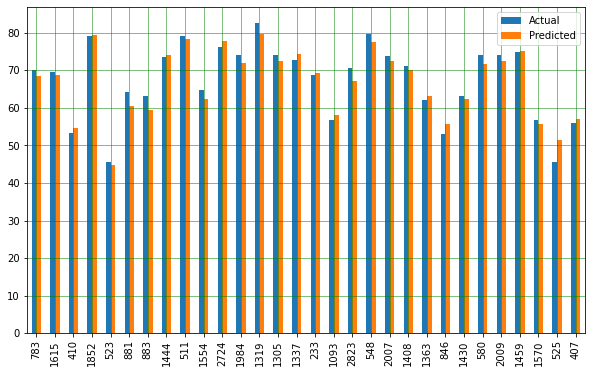

In [28]:
# visualise actual vs predicted
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

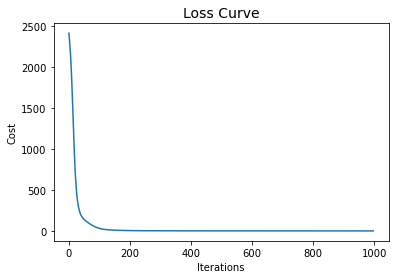

In [29]:
# plot the loss curve of the ML algorithm
plt.plot(mlp.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

# Predicting Life Expectancy 
### Given values for Alcohol, BMI and Adult Mortality, we can observe the ANN's ability to predict Life Expectancy

In [30]:
'''
Print an entry to use values for prediction
'''

print(reg_life_df.loc[[100]])

     STATUS  LIFE_EXPECTANCY  ALCOHOL  ADULT_MORTALITY  MEASLES  POLIO  \
100       0             73.9     4.09              128        0   96.0   

     DIPHTHERIA   BMI  INFANT_DEATHS  THINNESS_5-9_YEARS  \
100        95.0  51.9              1                 2.1   

     THINNESS_10-19_YEARS  SCHOOLING  INCOME_COMPOSITION_OF_RESOURCES  
100                   2.0       12.7                            0.729  


In [31]:
'''
initialize prediction data
'''

# here we're getting a life expectancy prediction for the given values
data = [[0.729, 51.9, 128]]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = [["INCOME_COMPOSITION_OF_RESOURCES", 'BMI', 'ADULT_MORTALITY']])
  
# print dataframe.
df

,INCOME_COMPOSITION_OF_RESOURCES,BMI,ADULT_MORTALITY
0,0.729,51.9,128


In [32]:
x = reg_life_df[["INCOME_COMPOSITION_OF_RESOURCES", "BMI", "ADULT_MORTALITY", "LIFE_EXPECTANCY"]]
z = df[["INCOME_COMPOSITION_OF_RESOURCES", 'BMI', 'ADULT_MORTALITY']]

In [33]:
# fit standardised features
scaler = sc.fit(z)

# transform train and test data
z_scaled = scaler.transform(z)

x_array = x.to_numpy()

mlp2 = MLPRegressor(hidden_layer_sizes=(50),
                   max_iter = 10000, 
                   activation = 'relu',
                   solver = 'adam').fit(x_array[:,:-1], x_array[:,-1])

predict_result = mlp2.predict(z_scaled)

# print prediction
print("Predicted Life Expectancy: ", predict_result)

Predicted Life Expectancy:  [48.31224392]


In [35]:
x = reg_life_df[["LIFE_EXPECTANCY", "ALCOHOL", "ADULT_MORTALITY", "BMI", "INFANT_DEATHS","MEASLES","POLIO","DIPHTHERIA","THINNESS_5-9_YEARS","THINNESS_10-19_YEARS", "SCHOOLING","INCOME_COMPOSITION_OF_RESOURCES"]]
y = reg_life_df["STATUS"]

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [39]:
X_smote, y_smote = SMOTE().fit_resample(x_train, y_train)

counter = Counter(y_smote)
print('After',counter)

gb_clf = GradientBoostingClassifier(loss='deviance',
                                    max_depth=10,
                                    learning_rate=0.5,
                                    n_estimators=600,
                                    random_state=42,
                                    criterion='friedman_mse',
                                    min_samples_split=0.01).fit(x_train, y_train)
gb_clf.fit(X_smote,y_smote)
pred = gb_clf.predict(x_test)

print(classification_report(y_test,pred))

After Counter({1: 1812, 0: 1812})
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       460
           1       0.96      0.98      0.97        88

    accuracy                           0.99       548
   macro avg       0.98      0.98      0.98       548
weighted avg       0.99      0.99      0.99       548



In [40]:
confusion_matrix(y_test,pred)

array([[456,   4],
       [  2,  86]])

In [45]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Lambda, MaxPooling2D, Dense, Dropout, Flatten # convolution layers & core layers

from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History

In [42]:
x = reg_life_df[["LIFE_EXPECTANCY", "ALCOHOL", "ADULT_MORTALITY", "BMI", "INFANT_DEATHS","MEASLES","POLIO","DIPHTHERIA","THINNESS_5-9_YEARS","THINNESS_10-19_YEARS", "SCHOOLING","INCOME_COMPOSITION_OF_RESOURCES"]].values
y = reg_life_df["STATUS"].values

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [46]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(12, kernel_initializer = "uniform",activation='relu', name='hidden_layer1', input_shape=(12,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(12, kernel_initializer = "uniform", activation='relu', name='hidden_layer2'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, name='output_layer')
])

2022-05-18 06:57:48.982819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 06:57:49.086414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 06:57:49.087088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 06:57:49.088269: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [47]:
model.compile(optimizer= "adam",loss = "binary_crossentropy",metrics = ["accuracy"])

In [48]:
model.fit(x_train, y_train, batch_size = 10, epochs = 5)

2022-05-18 06:57:53.828153: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
219/219 [==============================] - 2s 2ms/step - loss: 1.0617 - accuracy: 0.8108
Epoch 2/5
219/219 [==============================] - 0s 2ms/step - loss: 0.9464 - accuracy: 0.8122
Epoch 3/5
219/219 [==============================] - 0s 2ms/step - loss: 0.7082 - accuracy: 0.8286
Epoch 4/5
219/219 [==============================] - 0s 2ms/step - loss: 0.5205 - accuracy: 0.8483
Epoch 5/5
219/219 [==============================] - 1s 2ms/step - loss: 0.4565 - accuracy: 0.8505
